In [1]:
BASE_PATH = "/content/drive/MyDrive/Académico/UNIR/MUQC/99 - TFM/dev"

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
RANDOM_SEED = 1234

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
PCA_COMPONENTS = 8

In [6]:
df_tr_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/tr_day_syn.csv")

In [7]:
df_test_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/test_day_syn.csv")

In [8]:
x_tr = df_tr_day_syn_resampled.drop(columns = " Label").to_numpy()

In [9]:
y_tr = df_tr_day_syn_resampled[" Label"].to_numpy()

In [10]:
x_test = df_test_day_syn_resampled.drop(columns = " Label").to_numpy()

In [11]:
y_test = df_test_day_syn_resampled[" Label"].to_numpy()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5, stratify = y_test)

In [14]:
from sklearn.preprocessing import MaxAbsScaler

In [15]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [16]:
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components = PCA_COMPONENTS)

In [19]:
start = time.time()

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 0.5986385345458984 s


In [20]:
# import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Input(PCA_COMPONENTS),
    tf.keras.layers.Dense(8, activation = "elu"),
    tf.keras.layers.Dense(16, activation = "elu"),
    tf.keras.layers.Dense(8, activation = "elu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [21]:
LEARNING_RATE = 0.005
opt = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
model.compile(opt, loss = tf.keras.losses.BinaryCrossentropy())

PATIENCE = 2
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = PATIENCE, verbose = 1,
    restore_best_weights = True)

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


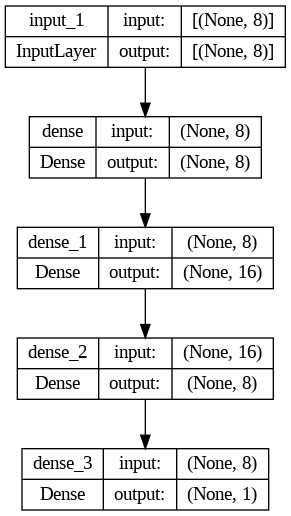

In [23]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [24]:
start = time.time()

In [25]:
EPOCHS = 50
BATCH_SIZE = 20

history = model.fit(xs_tr, y_tr, epochs = EPOCHS, shuffle = True,
                    validation_data = (xs_val, y_val),
                    batch_size = BATCH_SIZE,
                    callbacks = [earlystop])

Epoch 1/50
4000/4000 [==============================] - 8s 2ms/step - loss: 0.0092 - val_loss: 0.0296
Epoch 2/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0053 - val_loss: 0.0452
Epoch 3/50
4000/4000 [==============================] - 6s 2ms/step - loss: 0.0046 - val_loss: 0.0443
Epoch 3: early stopping


In [26]:
end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 21.436500787734985 s


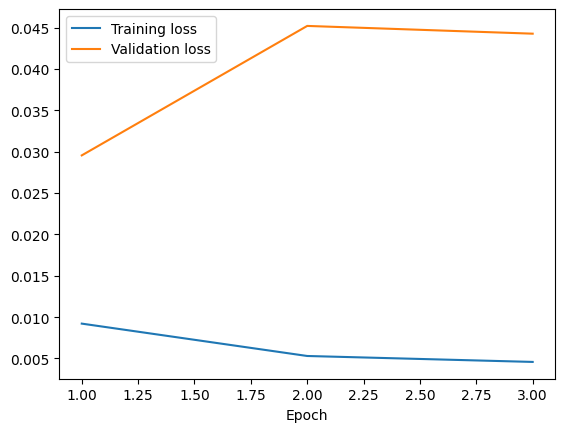

In [27]:
import matplotlib.pyplot as plt

def plot_losses(history):
  tr_loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = np.array(range(len(tr_loss))) + 1

  plt.plot(epochs, tr_loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

plot_losses(history)

In [28]:
from sklearn.metrics import accuracy_score

start = time.time()

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

end = time.time()
print(f"Elapsed time: {end - start} s")

313/313 [==============================] - 0s 999us/step
Elapsed time: 4.311840534210205 s


In [29]:
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.9990625
Validation accuracy: 0.9934
Test accuracy: 0.9941


In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
start = time.time()

output = model.predict(xs_test)
result = (output > 0.5).astype(float)

end = time.time()
print(f"Elapsed time: {end - start} s")

313/313 [==============================] - 0s 863us/step
Elapsed time: 0.39154815673828125 s


In [32]:
confusion_matrix(y_true = y_test, y_pred = result)

array([[8947,   53],
       [   6,  994]])

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_test, y_pred = result))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9000
           1       0.95      0.99      0.97      1000

    accuracy                           0.99     10000
   macro avg       0.97      0.99      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [34]:
from sklearn.metrics import roc_curve

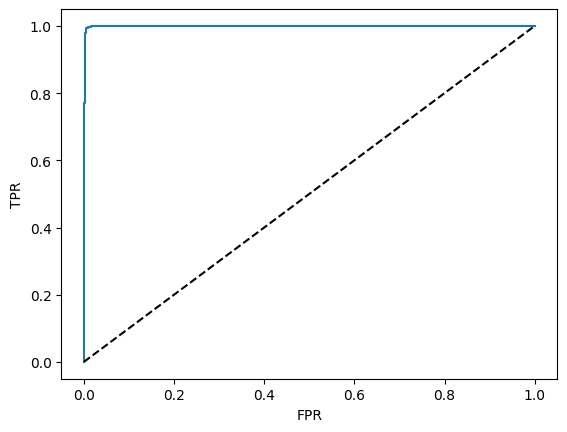

In [35]:
fpr, tpr, _ = roc_curve(y_test, output)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "black")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [36]:
from sklearn.metrics import auc

print(auc(fpr, tpr))

0.9988244444444445
